In [1]:
import DirectDmTargets as dddm

Host: DESKTOP-URE1BBI.localdomain
Setting tmp folder to /tmp/


In [2]:
import time

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tqdm import tqdm

In [5]:
import numericalunits as nu

In [6]:
import wimprates as wr

# Finding the correct 'factor' #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

25 october 2019 

## Goal ## 
- in the DetectorSpectrum-class a factor is used to rebin the DM-spectrum. This rebinning should be fine enough to allow the numerical integration to be sufficiently accurate. However we don't want a too fine binning as it does increase computation time drastically. 

## Result ##
A factor (the factor between the the bins used for the numerical integration and the spectrum) is set to **10** as this proved a fair trade off between speed and accuracy.

(1e-07, 10000000000.0)

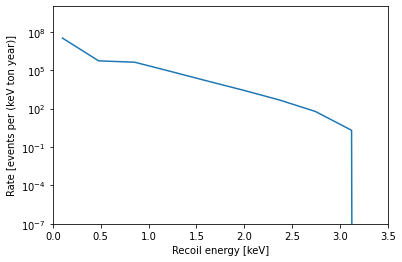

In [7]:
# NR's
energies = np.linspace(0.1, 3.5, 10)

# dr/dr
dr = ((nu.keV * (1000 * nu.kg) * nu.year) * 
    wr.rate_migdal(energies * nu.keV, 
                    mw=1 * nu.GeV/nu.c0**2, 
                    sigma_nucleon=1e-35 * nu.cm**2))

plt.plot(energies, dr, label="WIMPrates SHM")

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")

plt.xlim(0, energies.max())
plt.yscale("log")

plt.ylim(1e-7,1e10)
# dr

## Distribution of the DM ##
First we need to make a DM-rate spectrum (below we first compare the un-smeared and smeared spectrum)

In [8]:
use_SHM = dddm.SHM()

In [9]:
# No detector resolution
def plot_spectrum(data, yerr = True, color = 'blue', label = 'label', linestyle = 'none'):
    plt.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']) if yerr else np.zeros(len(data['counts'])),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                label = label
                )
def plot_spectrum_ax(ax, data, yerr = True, color = 'blue', label = 'label', linestyle = 'none'):
    ax.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']) if yerr else np.zeros(len(data['counts'])),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                label = label
                )
def get_gal_spec(det, mw = 1, sigma = 1e-35, nbins = 10):
    events = dddm.GenSpectrum(mw, sigma, use_SHM, dddm.experiment[det])
    events.n_bins = nbins
    return events.get_data(poisson = False)

In [10]:
def get_det_spec(det, mw = 1, sigma = 1e-35, nbins = 10, background = True,):
    events = dddm.DetectorSpectrum(mw, sigma, use_SHM, dddm.experiment[det])
    events.n_bins = nbins
    events.add_background = background
    return events.get_data(poisson = False)

In [11]:
plt.rcParams['axes.grid'] = True

def plot_spectra(det, mw = 1, sigma = 1e-35, nbins = 10):
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, figsize = (14,14), sharex = True)
    
    gal_spec = get_gal_spec(det, mw = mw, sigma = sigma, nbins = nbins)
    bg_spec = get_det_spec(det, mw = mw, sigma = sigma, nbins = nbins)
    no_bg_spec = get_det_spec(det, mw = mw, sigma = sigma, nbins = nbins, background = False)
    
    plot_spectrum_ax(ax1, gal_spec, color = 'red', 
                     label = f'{det} without det. parameters (gal_spec)')
    
    plot_spectrum_ax(ax1,bg_spec,color =  'black', 
                     label = f'{det} with background (bg_spec)')
   
    plot_spectrum_ax(ax1,no_bg_spec,color =  'blue', 
                     label = f'{det} without background (no_bg_spec)')
    
    ax1.set_ylim(bottom=np.max([plt.ylim()[-1], (1e-10 * 10/nbins)]))
#     ax1.legend()
    
    
#     ax1.set_ylim(np.min(no_bg_spec['counts'].values), 
#                  np.max(bg_spec['counts'].values) * 1.5)
    ax1.set_yscale("log")
#     ax1.grid(axis="both")
    
    plot_spectrum_ax(ax2, gal_spec, color = 'red', 
                     label = f'{det} without det. parameters')
    plot_spectrum_ax(ax2,bg_spec,color =  'black', 
                     label = f'{det} with background')
    plot_spectrum_ax(ax2,no_bg_spec,color =  'blue', 
                     label = f'{det} without background')
#     ax2.legend()
#     ax2.grid(axis="both")
    
    diff_bg = bg_spec.copy()
    diff_bg['counts'] = bg_spec['counts'] - no_bg_spec['counts']
    plot_spectrum_ax(ax3, diff_bg, color = 'orange',yerr = False, 
                     label = f'{det} background (bg - no_bg)')
#     ax3.legend()
#     ax3.grid(axis="both")
   
    diff_gal = gal_spec.copy()
    diff_gal['counts'] = gal_spec['counts'] - no_bg_spec['counts']
    plot_spectrum_ax(ax4,diff_gal, color = 'green', yerr = False, 
                     label = f'{det} gal-spec diff (gal. - no_bg)')
#     ax4.legend()
#     ax4.grid(axis="both")
    
    for ax in [ax1,ax2,ax3, ax4]:
        ax.axvline(dddm.experiment[det]['E_thr'], label = 'energy threshold')
        ax.grid(axis="both")
        ax.legend()

CPU times: user 25.2 s, sys: 266 ms, total: 25.5 s
Wall time: 26.3 s


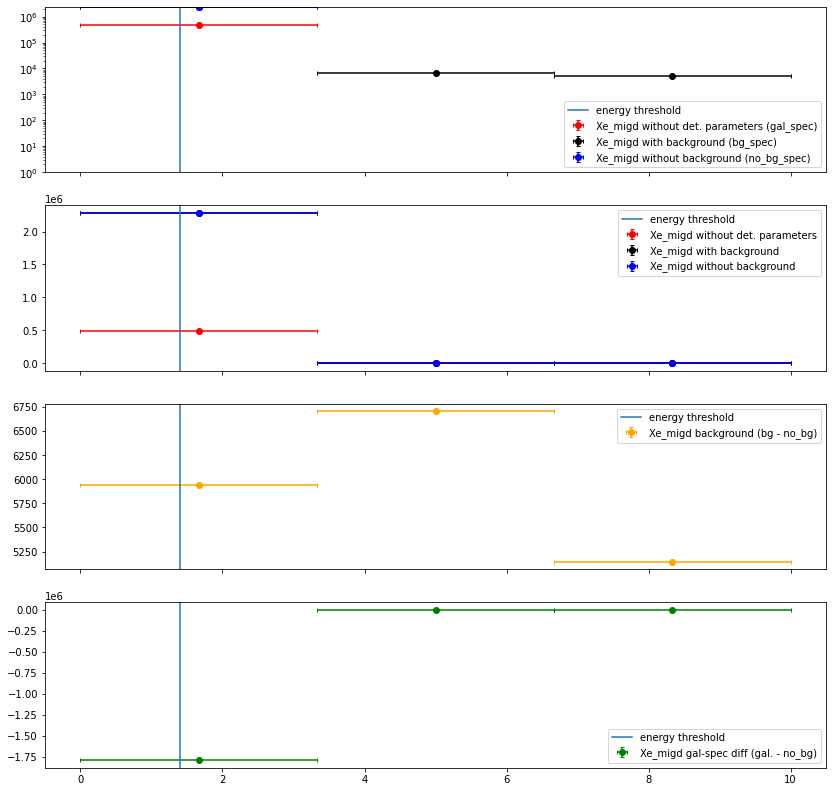

In [12]:
%%time
def temp_res(E):
    return 0.006 * np.sqrt(E)
dddm.experiment['Xe_migd']['res'] = temp_res
plot_spectra('Xe_migd', nbins = 3)

/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/detector.py:58: UserWarning: Deprication warning: use det_res_XENON1T_update
  warn('Deprication warning: use det_res_XENON1T_update')


CPU times: user 2min 53s, sys: 297 ms, total: 2min 54s
Wall time: 3min 1s


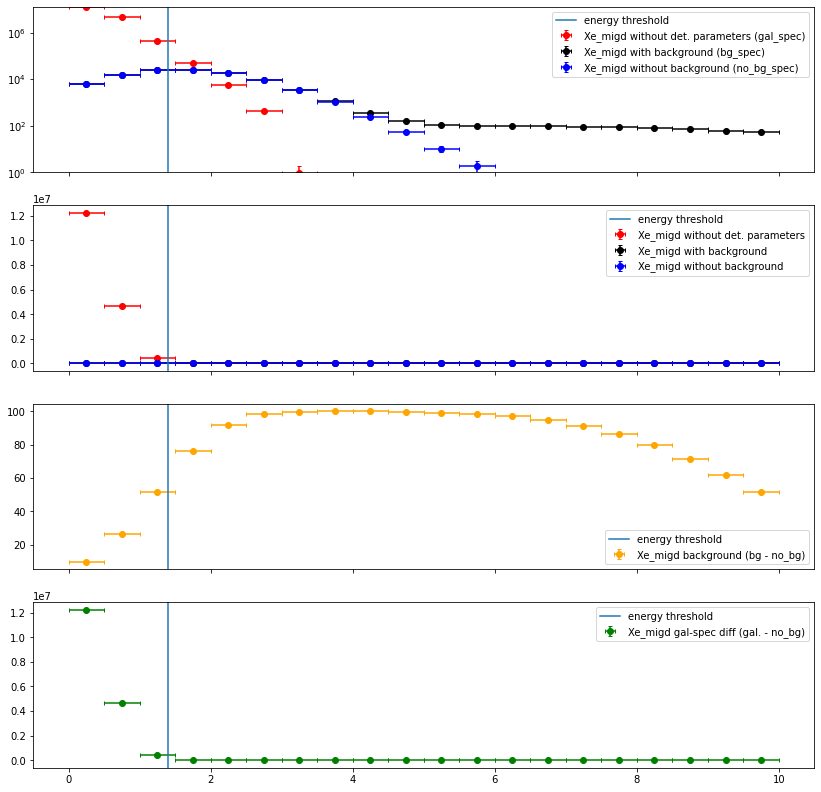

In [13]:
%%time
dddm.experiment['Xe_migd']['res'] = dddm.det_res_XENON1T
plot_spectra('Xe_migd', nbins = 20)

In [14]:
dddm.experiment['Xe_migd']['E_thr']

1.4

/mnt/d/Google_Drive/PhD-master/ubuntu-storage/windows-anaconda/DD_DM_targets/DirectDmTargets/detector.py:75: UserWarning: Warning use det_res_XENON1T_update() instead
  warn('Warning use det_res_XENON1T_update() instead')


CPU times: user 32 s, sys: 93.8 ms, total: 32.1 s
Wall time: 33 s


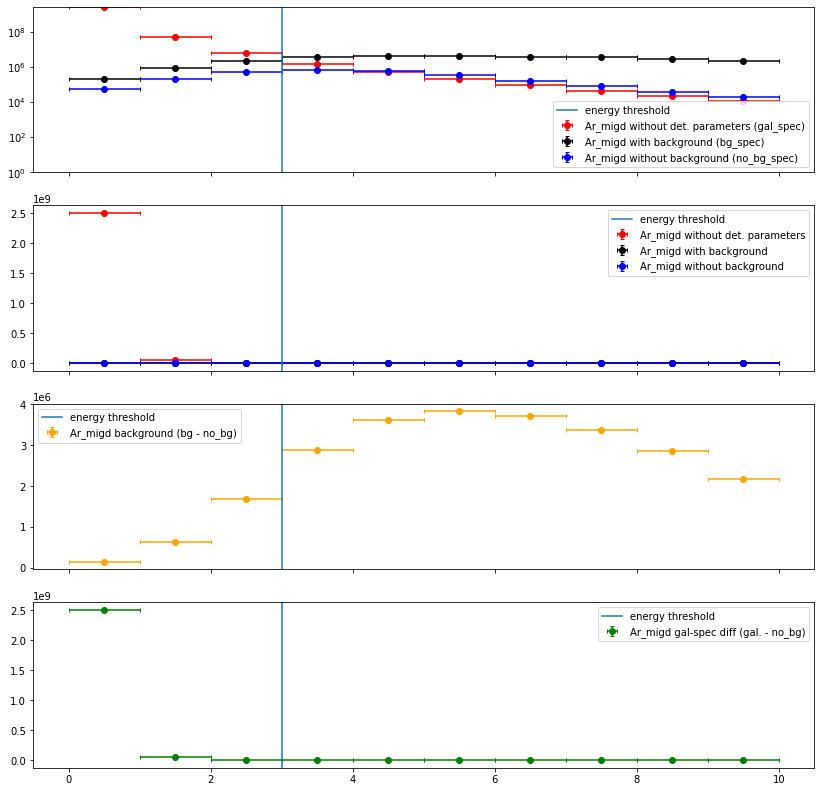

In [15]:
%%time
plot_spectra('Ar_migd', 10)

CPU times: user 52.3 s, sys: 234 ms, total: 52.6 s
Wall time: 55.5 s


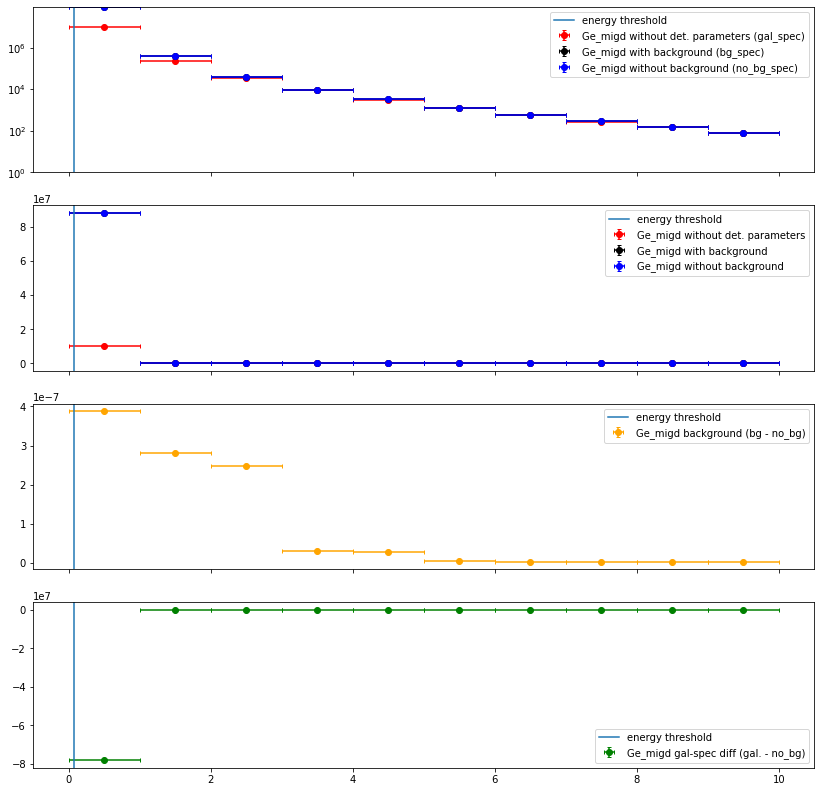

In [16]:
%%time
plot_spectra('Ge_migd', 10)

-- mw = 0.1 for Ge_migd -- 


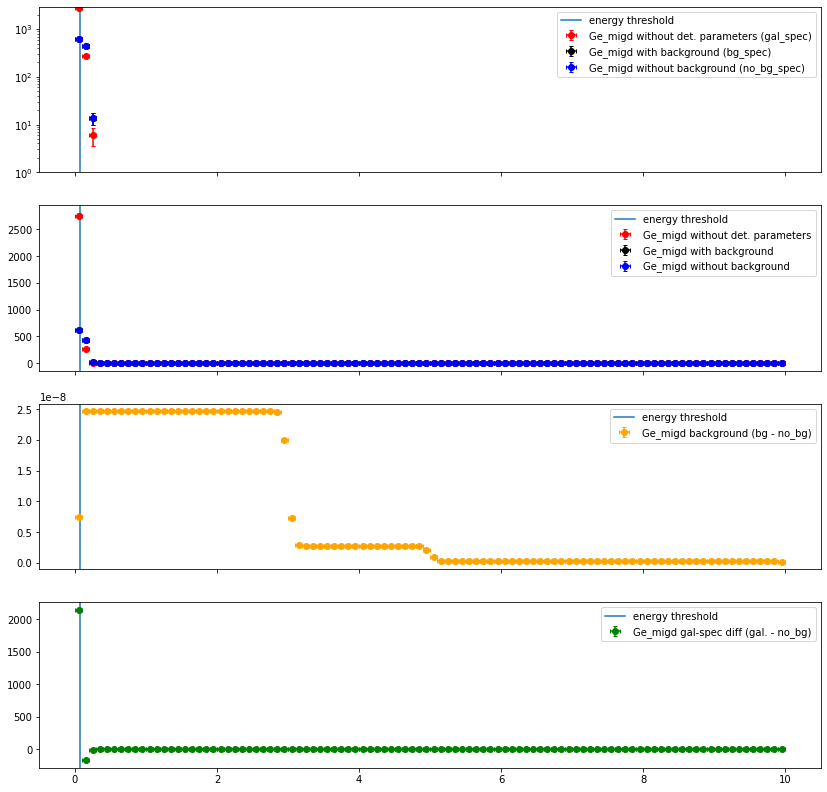

done in 410.14619994163513 s = 6 m

-- mw = 0.1 for Ge_migd -- 


In [ ]:
n_bins_dict = {'Ge_migd':[100, 1000], 'Xe_migd':[100], 'Ar_migd':[100]}
for mw in [0.1, 1, 5]:
    for det in ['Ge_migd', 'Xe_migd', 'Ar_migd']:
        for nbins in n_bins_dict[det]:
            t0 = time.time()
            print(f'-- mw = {mw} for {det} -- ')
            plot_spectra(det, mw = mw, nbins = nbins)
            for f_type in  ['png', 'pdf']:
                plt.savefig(f'figures/spectrum_{det}_mw-{mw}_nbin-{nbins}.{f_type}', dpi = 100)
            plt.show()
            print(f'done in {time.time() -t0} s = {int((time.time() -t0)/60)} m')
            print()

## Finding the correct factor ##

In [ ]:
stats_ge = dddm.NestedSamplerStatModel("Ge")
stats_ge.get_summary()

In [ ]:
stats_ge.check_spectrum()

In [ ]:
stats_xe = dddm.NestedSamplerStatModel("Xe")
stats_xe.sampler = 'multinest'
stats_xe.get_summary()

In [ ]:
stats_xe.check_spectrum()

In [ ]:
stats_ar = dddm.NestleStatModel("Ar")
stats_ar.get_summary()

In [ ]:
stats_ar.check_spectrum()

# Update resolution after  https://arxiv.org/abs/2003.03825

In [ ]:
def fun(E):
    a = 31.71
    b = 0.15
    sigma_over_E = b + a/np.sqrt(E)
    return sigma_over_E/100

def sigma(E):
    return fun(E)*E


In [ ]:
ens = np.linspace(0,3000, 100)
plt.figure(figsize=(8,4))
plt.plot(ens, 100 * 
         fun(ens))
plt.title('REPLICATION figure 6 https://arxiv.org/abs/2003.03825')
plt.xlabel('E [keV]')
plt.ylabel('$\sigma/E$ [%]')
plt.ylim(0,5)
plt.xlim(0,3000)
plt.grid()

In [ ]:
ens = np.linspace(0.001,10, 100)
plt.figure(figsize=(5,3))
plt.plot(ens, sigma(ens)/ens, label = 'XENON1T')
plt.plot(ens, dddm.det_res_XENON1T(ens)/ens, label = 'XENONnT')
plt.plot(ens, dddm.det_res_superCDMS(ens)/ens, label = 'superCDMS')
plt.ylim(0,1)
plt.xlim(0,ens[-1])
plt.legend()
plt.grid()
plt.xlabel('')